In [5]:
import pandas as pd
import json
from pathlib import Path

In [6]:
DATA = Path.cwd().parent / 'data'
SUMM_FOLDER = DATA / 'summaries_finetune'
TEXT_FILES = SUMM_FOLDER / 'text_files_copy'
SOURCE_TEXTS = SUMM_FOLDER / 'source_texts_clean'

In [10]:
data = open(DATA / 'source_dict.txt', 'r')
source_dict = json.loads(data.read())
source_texts = list(source_dict.values())

In [79]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig
from transformers import DataCollatorForLanguageModeling, LongformerForMaskedLM

import torch
seed = 42
max_length = 4096
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name, model_max_length = max_length)

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)


def tokenizeForMLM(batch):
    return tokenizer(batch['text'], return_special_tokens_mask = True, truncation=True)

mlm_df = df[['text']].dropna()
ds = Dataset.from_pandas(mlm_df, preserve_index=False)


In [83]:
mlm_ds = ds.map(tokenizeForMLM, batched=True)

# this generates labels by copying the input ids
def group_texts(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

mlm_ds = mlm_ds.map(group_texts, batched=True)

# this generates labels by copying the input ids
def group_texts(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

mlm_ds = mlm_ds.map(group_texts, batched=True)

  0%|          | 0/93 [00:00<?, ?ba/s]

  0%|          | 0/93 [00:00<?, ?ba/s]

  0%|          | 0/93 [00:00<?, ?ba/s]

In [84]:
# generate train and valid sets
def buildDataset(ds):
    full_dataset = ds
    # 70% train, 30% test
    train_valid = full_dataset.train_test_split(test_size=0.15, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_valid['train'],
        'valid': train_valid['test']})
    return final_dataset
mlm_ds = buildDataset(mlm_ds)
mlm_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 78543
    })
    valid: Dataset({
        features: ['text', 'input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 13861
    })
})

<AxesSubplot:>

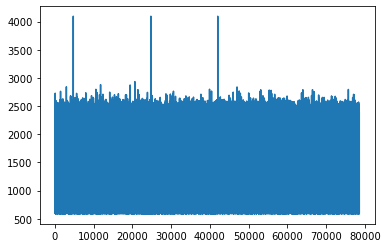

In [88]:
pd.Series([len(seq) for seq in mlm_ds['train']['input_ids']]).plot()

In [85]:
# Show the training loss with every epoch

import torch
seed = 42
model_name = 'allenai/longformer-base-4096'
#torch.cuda.empty_cache()
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)


def model_init():
    return LongformerForMaskedLM.from_pretrained(model_name).to(device)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15) 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,

)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=mlm_ds["train"],
    eval_dataset=mlm_ds["valid"],
    data_collator=data_collator,
)

trainer.train()

loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_

cuda


loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /home/jovyan/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d
All model checkpoint weights were used when initializing LongformerForMaskedLM.

Some weights of LongformerForMaskedLM were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /home/jovyan/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.